In [1]:
# Loading the proper libraries
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
# Compose some tanransforms and load the data using dataloader
# Transforms include making them Tensor and Normalize the images
# can include many more like resize,crop etc
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Set the dataloaders
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%

Files already downloaded and verified


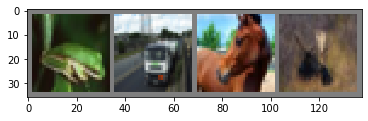

 frog truck horse  deer


In [39]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [172]:
import torch.nn as nn
import torch.nn.functional as F

# Create the Neural Netwrok using Convulotion layers and fully connected layers
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
         # 3 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 300, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(300, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 200)
        self.fc2 = nn.Linear(200, 120)
        self.fc3 = nn.Linear(120, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


In [173]:
import torch.optim as optim

# Create the loss and Optimizer for the network so we can train and change the weights
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [174]:
# Actual Trainging
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

net.to(device)
print(net)
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')


cuda
Net(
  (conv1): Conv2d(3, 300, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(300, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)
[1,  2000] loss: 1.989
[1,  4000] loss: 1.645
[1,  6000] loss: 1.513
[1,  8000] loss: 1.437
[1, 10000] loss: 1.380
[1, 12000] loss: 1.356
[2,  2000] loss: 1.271
[2,  4000] loss: 1.251
[2,  6000] loss: 1.216
[2,  8000] loss: 1.177
[2, 10000] loss: 1.165
[2, 12000] loss: 1.124
Finished Training


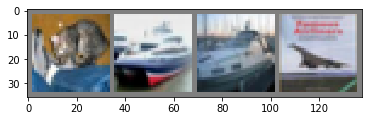

GroundTruth:    cat  ship  ship plane


In [175]:
# Testing the neural
dataiter = iter(testloader)
images, labels = dataiter.next()

# Print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [176]:
net.to(device)

images = images.to(torch.device("cuda"))

print(next(net.parameters()).device)
print(images.device)

outputs = net(im)
_, predicted = torch.max(outputs,1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

cuda:0
cuda:0
Predicted:    cat  ship  ship plane


In [177]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        #print(predicted.device)
        #print(labels.device)
        correct += (predicted == labels).sum().item()
    
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
   

Accuracy of the network on the 10000 test images: 58 %


In [178]:
class_correct = list(0. for i in range(10))
class_total = list(0.001 for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs,1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 49 %
Accuracy of   car : 59 %
Accuracy of  bird : 63 %
Accuracy of   cat : 35 %
Accuracy of  deer : 41 %
Accuracy of   dog : 28 %
Accuracy of  frog : 82 %
Accuracy of horse : 59 %
Accuracy of  ship : 78 %
Accuracy of truck : 82 %
